# Experiment: GNN Failure Risk Audit (Minimal)

Objective:
- Verify that homophily affects GNN accuracy on simple synthetic graphs.


In [1]:
# Colab install (minimal)
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'torch-geometric', 'scipy', 'networkx'])
else:
    print('Local run detected. Ensure torch-geometric + scipy + networkx are installed.')


Local run detected. Ensure torch-geometric + scipy + networkx are installed.


In [4]:
# Imports + seed + device
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

import pandas as pd

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

import matplotlib.pyplot as plt


/Users/matthew/Desktop/OrgApplications/MASTERS/Cam/Courses/GeometricDL/GDL/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [5]:
# Synthetic data (SBM)

def make_sbm(num_nodes=200, p_in=0.1, p_out=0.01, num_classes=2, feat_dim=16, seed=0):
    rng = np.random.default_rng(seed)
    sizes = [num_nodes // num_classes for _ in range(num_classes)]
    sizes[0] += num_nodes - sum(sizes)
    probs = [[p_in if i == j else p_out for j in range(num_classes)] for i in range(num_classes)]

    G = nx.stochastic_block_model(sizes, probs, seed=seed)
    labels = []
    for c, size in enumerate(sizes):
        labels.extend([c] * size)
    labels = np.array(labels)

    features = rng.normal(size=(num_nodes, feat_dim)).astype(np.float32)
    features += 0.1 * rng.normal(size=(num_nodes, feat_dim)).astype(np.float32) * labels[:, None]

    data = from_networkx(G)
    data.x = torch.tensor(features, dtype=torch.float)
    data.y = torch.tensor(labels, dtype=torch.long)
    return data

def homophily_ratio(edge_index, labels):
    src, dst = edge_index
    same = (labels[src] == labels[dst]).float()
    return same.mean().item() if same.numel() > 0 else 0.0


In [6]:
# Models + training helpers
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x, edge_index=None):
        return self.net(x)

class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


def split_indices(n, train_ratio=0.6, val_ratio=0.2, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    train_idx = torch.tensor(idx[:n_train], dtype=torch.long)
    val_idx = torch.tensor(idx[n_train:n_train + n_val], dtype=torch.long)
    test_idx = torch.tensor(idx[n_train + n_val:], dtype=torch.long)
    return train_idx, val_idx, test_idx


def train_epoch(model, data, train_idx, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_acc(model, data, idx):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=-1)
        acc = (pred[idx] == data.y[idx]).float().mean().item()
    return acc

class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1, concat=False)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x


## What this experiment does
- Creates three synthetic graph families with increasing heterophily.
- Trains four models (MLP, GCN, GraphSAGE, GAT) on each graph.
- Computes homophily ratio for each graph and plots it against test accuracy.
- Goal: visually test whether higher homophily predicts higher GNN accuracy.


seed=42, p_in=0.12, p_out=0.01, MLP test_acc=0.450
seed=42, p_in=0.12, p_out=0.01, GCN test_acc=0.900
seed=42, p_in=0.12, p_out=0.01, GraphSAGE test_acc=0.725
seed=42, p_in=0.12, p_out=0.01, GAT test_acc=1.000
seed=43, p_in=0.12, p_out=0.01, MLP test_acc=0.400
seed=43, p_in=0.12, p_out=0.01, GCN test_acc=0.975
seed=43, p_in=0.12, p_out=0.01, GraphSAGE test_acc=0.700
seed=43, p_in=0.12, p_out=0.01, GAT test_acc=1.000
seed=44, p_in=0.12, p_out=0.01, MLP test_acc=0.425
seed=44, p_in=0.12, p_out=0.01, GCN test_acc=0.850
seed=44, p_in=0.12, p_out=0.01, GraphSAGE test_acc=0.675
seed=44, p_in=0.12, p_out=0.01, GAT test_acc=0.875
seed=45, p_in=0.12, p_out=0.01, MLP test_acc=0.350
seed=45, p_in=0.12, p_out=0.01, GCN test_acc=0.375
seed=45, p_in=0.12, p_out=0.01, GraphSAGE test_acc=0.550
seed=45, p_in=0.12, p_out=0.01, GAT test_acc=0.900
seed=46, p_in=0.12, p_out=0.01, MLP test_acc=0.525
seed=46, p_in=0.12, p_out=0.01, GCN test_acc=0.900
seed=46, p_in=0.12, p_out=0.01, GraphSAGE test_acc=0.725
s

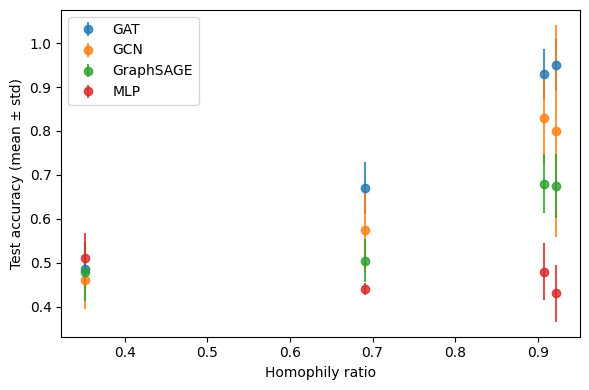

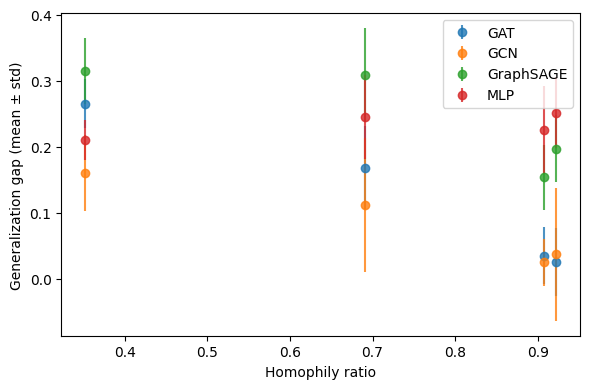

Correlation (risk_score vs test_acc_mean):
GAT -0.980
GCN -0.957
GraphSAGE -0.899
MLP 0.680


In [7]:
# Run (4 settings, 4 models) with multiple seeds
settings = [
    (0.12, 0.01),  # very homophilic
    (0.10, 0.01),  # homophilic
    (0.07, 0.03),  # mixed
    (0.03, 0.05),  # heterophilic
]

num_seeds = 5
rows = []

for p_in, p_out in settings:
    for s in range(num_seeds):
        seed = SEED + s
        data = make_sbm(p_in=p_in, p_out=p_out, seed=seed)
        data = data.to(DEVICE)
        train_idx, val_idx, test_idx = split_indices(data.num_nodes, seed=seed)
        h_ratio = homophily_ratio(data.edge_index, data.y)

        for model_name, model in [
            ('MLP', MLP(data.num_features, 32, 2)),
            ('GCN', GCN(data.num_features, 32, 2)),
            ('GraphSAGE', GraphSAGE(data.num_features, 32, 2)),
            ('GAT', GAT(data.num_features, 32, 2)),
        ]:
            model = model.to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            for _ in range(50):
                train_epoch(model, data, train_idx, optimizer)
            train_acc = eval_acc(model, data, train_idx)
            test_acc = eval_acc(model, data, test_idx)
            rows.append({
                'p_in': p_in,
                'p_out': p_out,
                'homophily': h_ratio,
                'seed': seed,
                'model': model_name,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'gen_gap': train_acc - test_acc,
            })
            print(f"seed={seed}, p_in={p_in:.2f}, p_out={p_out:.2f}, {model_name} test_acc={test_acc:.3f}")

print("Summary table (raw):")
df = pd.DataFrame(rows)
print(df.head())

# Aggregate
agg = df.groupby(['model', 'p_in', 'p_out']).agg(
    homophily=('homophily', 'mean'),
    test_acc_mean=('test_acc', 'mean'),
    test_acc_std=('test_acc', 'std'),
    gen_gap_mean=('gen_gap', 'mean'),
    gen_gap_std=('gen_gap', 'std'),
).reset_index()

print("Summary table (mean ± std):")
print(agg)

# Plot 1: mean accuracy vs homophily
plt.figure(figsize=(6, 4))
for model, g in agg.groupby('model'):
    plt.errorbar(g['homophily'], g['test_acc_mean'], yerr=g['test_acc_std'], fmt='o', label=model, alpha=0.8)
plt.xlabel('Homophily ratio')
plt.ylabel('Test accuracy (mean ± std)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: generalization gap vs homophily
plt.figure(figsize=(6, 4))
for model, g in agg.groupby('model'):
    plt.errorbar(g['homophily'], g['gen_gap_mean'], yerr=g['gen_gap_std'], fmt='o', label=model, alpha=0.8)
plt.xlabel('Homophily ratio')
plt.ylabel('Generalization gap (mean ± std)')
plt.legend()
plt.tight_layout()
plt.show()

# Simple risk score proxy: inverse homophily
# (higher risk when homophily is low)
agg['risk_score'] = 1.0 - agg['homophily']

# Correlation between risk score and accuracy (per model)
print("Correlation (risk_score vs test_acc_mean):")
for model, g in agg.groupby('model'):
    corr = g['risk_score'].corr(g['test_acc_mean'])
    print(model, f"{corr:.3f}")


## Alignment (Feature-Signal) Sweep
We now keep graph structure fixed and vary how much label signal is present in node features.
This probes the misalignment idea: when features are weakly aligned with labels, GNN performance should drop.


Alignment sweep (mean ± std):
        model  feature_strength  test_acc_mean  test_acc_std
0         GAT               0.0          0.940      0.041833
1         GAT               0.1          0.960      0.033541
2         GAT               0.3          0.950      0.046771
3         GAT               0.6          0.970      0.011180
4         GCN               0.0          0.850      0.053033
5         GCN               0.1          0.905      0.064711
6         GCN               0.3          0.835      0.112639
7         GCN               0.6          0.875      0.035355
8   GraphSAGE               0.0          0.755      0.100623
9   GraphSAGE               0.1          0.710      0.074162
10  GraphSAGE               0.3          0.700      0.136931
11  GraphSAGE               0.6          0.745      0.044721
12        MLP               0.0          0.545      0.051235
13        MLP               0.1          0.500      0.058630
14        MLP               0.3          0.475      0.0

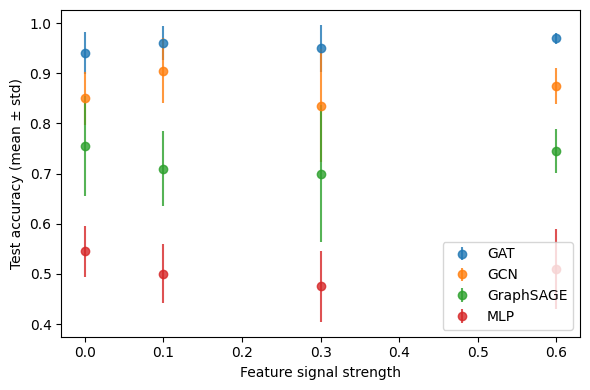

In [8]:
# Alignment sweep (vary feature strength)
feature_strengths = [0.0, 0.1, 0.3, 0.6]

rows_align = []

# Fix graph structure to a moderately homophilic regime
p_in, p_out = (0.10, 0.01)

for fs in feature_strengths:
    for s in range(num_seeds):
        seed = SEED + 100 + s
        data = make_sbm(p_in=p_in, p_out=p_out, seed=seed)
        data = data.to(DEVICE)

        # overwrite features with controllable signal strength
        rng = np.random.default_rng(seed)
        features = rng.normal(size=(data.num_nodes, data.num_features)).astype(np.float32)
        features += fs * rng.normal(size=(data.num_nodes, data.num_features)).astype(np.float32) * data.y.cpu().numpy()[:, None]
        data.x = torch.tensor(features, dtype=torch.float, device=DEVICE)

        train_idx, val_idx, test_idx = split_indices(data.num_nodes, seed=seed)

        for model_name, model in [
            ('MLP', MLP(data.num_features, 32, 2)),
            ('GCN', GCN(data.num_features, 32, 2)),
            ('GraphSAGE', GraphSAGE(data.num_features, 32, 2)),
            ('GAT', GAT(data.num_features, 32, 2)),
        ]:
            model = model.to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            for _ in range(50):
                train_epoch(model, data, train_idx, optimizer)
            test_acc = eval_acc(model, data, test_idx)
            rows_align.append({
                'feature_strength': fs,
                'seed': seed,
                'model': model_name,
                'test_acc': test_acc,
            })

align_df = pd.DataFrame(rows_align)

agg_align = align_df.groupby(['model', 'feature_strength']).agg(
    test_acc_mean=('test_acc', 'mean'),
    test_acc_std=('test_acc', 'std'),
).reset_index()

print("Alignment sweep (mean ± std):")
print(agg_align)

plt.figure(figsize=(6, 4))
for model, g in agg_align.groupby('model'):
    plt.errorbar(g['feature_strength'], g['test_acc_mean'], yerr=g['test_acc_std'], fmt='o', label=model, alpha=0.8)
plt.xlabel('Feature signal strength')
plt.ylabel('Test accuracy (mean ± std)')
plt.legend()
plt.tight_layout()
plt.show()


## Real Datasets (Colab)
We now run a small check on Cora and CiteSeer. This section downloads datasets in Colab and may take a minute.


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_undirected

REAL_DATASETS = ["Cora", "CiteSeer"]
num_seeds_real = 5

real_rows = []
for name in REAL_DATASETS:
    dataset = Planetoid(root="/content/planetoid" if IN_COLAB else "output/datasets/Planetoid", name=name)
    data = dataset[0]
    data.edge_index = to_undirected(data.edge_index)
    data = data.to(DEVICE)

    train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
    val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
    test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)

    h_ratio = homophily_ratio(data.edge_index, data.y)

    for s in range(num_seeds_real):
        seed = SEED + 1000 + s
        torch.manual_seed(seed)

        for model_name, model in [
            ('MLP', MLP(data.num_features, 32, int(data.y.max().item()) + 1)),
            ('GCN', GCN(data.num_features, 32, int(data.y.max().item()) + 1)),
            ('GraphSAGE', GraphSAGE(data.num_features, 32, int(data.y.max().item()) + 1)),
            ('GAT', GAT(data.num_features, 32, int(data.y.max().item()) + 1)),
        ]:
            model = model.to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            for _ in range(100):
                train_epoch(model, data, train_idx, optimizer)
            test_acc = eval_acc(model, data, test_idx)
            real_rows.append({
                'dataset': name,
                'homophily': h_ratio,
                'seed': seed,
                'model': model_name,
                'test_acc': test_acc,
            })

real_df = pd.DataFrame(real_rows)

agg_real = real_df.groupby(['dataset', 'model']).agg(
    homophily=('homophily', 'mean'),
    test_acc_mean=('test_acc', 'mean'),
    test_acc_std=('test_acc', 'std'),
).reset_index()

print(agg_real)

plt.figure(figsize=(6, 4))
for model, g in agg_real.groupby('model'):
    plt.errorbar(g['homophily'], g['test_acc_mean'], yerr=g['test_acc_std'], fmt='o', label=model, alpha=0.8)
plt.xlabel('Homophily ratio')
plt.ylabel('Test accuracy (mean ± std)')
plt.legend()
plt.tight_layout()
plt.show()
